In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P2/"

## my .py : 
import read_csv
import preprocess
import list_from_data_field 
import missing_values_treatment

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer


My preprocess consisted in :
* Read the data : I only kept data with the "nutrition score" for this analyse,
* Drop the columns with too many missing values
* Select the variables that will interest me : the nutrition variable, with name of the product, its code reference, country of sell, and name of the person that inter it in the open food fact base.
* Merge the two columns that are about the palm oil ingredients.
* Remove outliers (from the semantic of columns, and compared to the other float values with hierarchical clustering)

**Mon prétraitement consistait en :**
* **Lecture des données : Je n'ai gardé que les données avec le "score nutritionnel" pour cette analyse,**
* **Suppression des colonnes avec trop de valeurs manquantes**
* **Sélection des variables d'intérêt : la variable nutritionnelle, avec le nom du produit, sa référence de code, le pays de vente, et le nom de la personne qui l'a introduit dans la base de données 'open food facts'.**
* **Fusion des deux colonnes qui concernent les ingrédients de l'huile de palme.**
* **Fusion des doublons (par nom de produit)**
* **Suppression les valeurs aberrantes (de la sémantique des colonnes, et par rapport aux autres valeurs avec une classification hierarchique).**


# 1. Suppression des variables sans intérêt :

In [2]:
##
## read data : 
##

df_original = pd.read_csv(data_path+"projet2/df_original.csv", 
                          low_memory=False, index_col=0)

print("In original data :", df_original.shape[0],
      " products and ", df_original.shape[1],"variables")
print("Total NaNs = ", df_original.isna().sum().sum(), 
      "(that is ",np.round(100*df_original.isna().sum().sum()/(
        df_original.shape[0]*df_original.shape[1]),2), "%)")

In original data : 646576  products and  184 variables
Total NaNs =  86150807 (that is  72.41 %)


In [3]:
df = df_original.copy()

##
## select variables 
##
list_of_nutri_facts = list_from_data_field.list_of_nutri_facts
interest_var = pd.Index(["code","product_name","creator","countries",
                         "additives_n","ingredients_from_palm_oil"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))
df = preprocess.select_columns(df, interest_var)


##
## set dtype : 
##
df = preprocess.set_dtypes(df)

##
## merge "from palm oil" 
##
df = preprocess.merge_palm_oil_cols(df)

##
## drop empty columns
##
nan_repartition = df_original.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.75)
df = preprocess.preprocess_drop_col_nan(df_original, nan_threshold)

print("I droped variables with less than", 
      df.shape[0]-np.floor(nan_threshold),
      " values")
print("I have dropped", df_original.shape[1]-df.shape[1], "variables")

I droped variables with less than 60.0  values
I have dropped 46 variables


In [4]:
print("In data after preprocess :", df.shape[0],
      " products and ", df.shape[1],"variables")
print("Total NaNs = ", df.isna().sum().sum(), 
      "(that is ",np.round(100*df.isna().sum().sum()/(
        df.shape[0]*df.shape[1]),2), "%)")

In data after preprocess : 646576  products and  138 variables
Total NaNs =  56408865 (that is  63.22 %)


# 2. Doublons

To drop duplicates, I compute a hierarchical clustering on the euclidean distance matrix of products with the same name, and I saved the indexes to gather in a dictionnary : 

**Pour éliminer les doublons, je calcule un clustering hiérarchique sur la matrice de distance euclidienne des produits de même nom, et je sauvegarde les index à rassembler dans un dictionnaire :** 
```python
# prod_name = "Salade de carottes râpées"
prod_name = "Abondance"
res = {}

x = data[data.product_name == prod_name]
prod_index = x.index
## if there is more than one product with the same name 
if len(prod_index) > 1 : 
    prod_values = data_float.loc[prod_index,:]
    prod_dist = pd.DataFrame(nan_euclidean_distances(prod_values),
                          columns=prod_index, index = prod_index)
    Z = linkage(prod_dist, "weighted")
    prod_clustering = pd.Series(fcluster(Z, t=1.15), index = prod_index)
    for k in np.unique(prod_clustering.values):
        index_merge = prod_clustering[prod_clustering==k].index
        res[prod_name+str(k)]= index_merge

```

In [5]:
##
## Extract float data 
##

float_var = list_from_data_field.list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil","ingredients_from_palm_oil_n"]
float_var = df.columns.intersection(float_var).values

data_columns = np.insert(float_var, 0, "product_name")
data = df[data_columns].copy()

##
## Extract duplicates to be merge
##

# import pickle

# res = get_index_merge_duplicates(data, float_var, 1.15)
# with open(res_path +'index_to_merge_duplicates.pkl', 'wb') as fp:
#     pickle.dump(res, fp, pickle.HIGHEST_PROTOCOL)
# with open(res_path +'index_to_merge_duplicates.pkl', 'rb') as f:
#     res = pickle.load(f)
    
##
## Merge duplicates from the dict
##

# data_clean = preprocess.drop_and_merge_duplicates(data)
# data_clean.to_csv(res_path+"data_duplicate_treated.csv")

## checkpoint : ##
data = pd.read_csv(res_path+"data_duplicate_treated.csv", index_col=0)


In [6]:
##
## drop empty columns
##
nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.75)
data = preprocess.preprocess_drop_col_nan(data, nan_threshold)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      " values")
print("I have dropped", data.shape[1]-data.shape[1], "variables")

I drop variables with less than 791.0  values
I have dropped 0 variables


In [7]:
print("In data after tackling duplicates :", data.shape[0],
      " products and ", data.shape[1],"variables")
print("Total NaNs = ", data.isna().sum().sum(), 
      "(that is ",np.round(100*data.isna().sum().sum()/(
        data.shape[0]*data.shape[1]),2), "%)")

In data after tackling duplicates : 460471  products and  43 variables
Total NaNs =  12932209 (that is  65.31 %)


# 3. Valeurs abérrantes

Then, I used the following function to set the possible values and remove the outliers 

**J'ai ensuite utilisé la fonction suivante pour définir les valeurs possibles et supprimer les valeurs aberrantes**

outliers products : ["happy'box" 'All-in Mix pour pain omega 3' 'παξιμάδι'
 'mousse foie de canard' 'France Lait pour nourrissons 0-6 mois'
 'barres céréales' 'Truffes Bergamote' '16 gougeres gratinees'
 'Edamer mild und zart' 'Asia Style Chicken' 'Feuerkrainer'
 'Lait - Eclats de noisettes' 'tosty pszenny' 'Crunchy Edamame'
 'salgadinhos reizinho' 'Yaki nori' 'Chocolate Cream Wafer'
 'Macadamia Hazelnut with Peanuts and Seeds Bar' 'Bruschetta' 'Cargando…'
 'Megachok'] 



array([  8400. ,  14744.3,   7610. ,   6140. ,  21557. ,   7770. ,
         5227. ,  11421. ,  13003.2,  31246. ,  11089.6,  10333. ,
         7240. ,  86200. ,  25200. ,   8700. , 547528.5,  11052. ,
         7660. ])

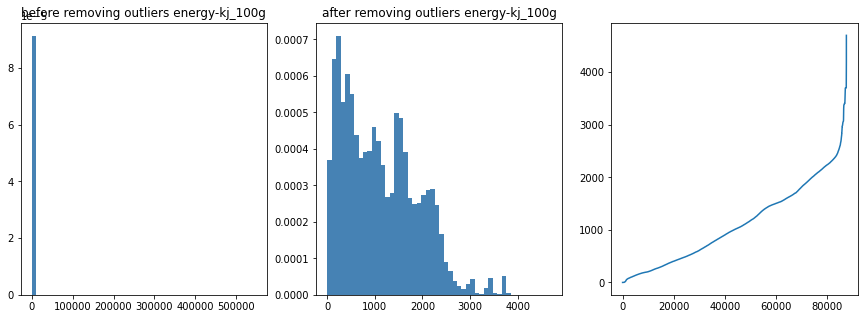

In [8]:
import missing_values_treatment
missing_values_treatment.help_to_set_outliers_vals(data,'energy-kj_100g', [0,5000])

In [9]:
##
## from the hyp that the variable has been entered in mg instead of g -> rescale 
##
data = missing_values_treatment.rescale_outliers100g_val(data)

##
## drop outliers values and drop product/variables with too many NaNs
##
data = missing_values_treatment.drop_outliers(data)
data.shape

(363519, 32)

In [10]:
print("In data after removing outliers :", data.shape[0],
      " products and ", data.shape[1],"variables")
print("Total NaNs = ", data.isna().sum().sum(), 
      "(that is ",np.round(100*data.isna().sum().sum()/(
        data.shape[0]*data.shape[1]),2), "%)")

In data after removing outliers : 363519  products and  32 variables
Total NaNs =  5778219 (that is  49.67 %)


# 4. Imputation valeurs manquantes

In [23]:
from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer

X = data.drop(["product_name", "nutrition-score-fr_100g"], axis=1).copy()

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)


## 4.1 Choix du nombre de voisin dans KNN

In [12]:
sub_X_std = X_std.sample(int(X_std.shape[0]/10))

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,30,4)}
cv = 3

# res = missing_values_treatment.launch_my_pseudo_CV(sub_X_std,my_meth,param_grid, cv = cv)
## Save dictionnary of results : 
# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
        res = pickle.load(f)

MSE = 563.133 (+/-52.064) for {'n_neighbors': 1}
MSE = 463.788 (+/-35.748) for {'n_neighbors': 5}
MSE = 440.202 (+/-39.485) for {'n_neighbors': 9}
MSE = 429.047 (+/-44.761) for {'n_neighbors': 13}
MSE = 423.787 (+/-46.777) for {'n_neighbors': 17}
MSE = 419.798 (+/-49.063) for {'n_neighbors': 21}
MSE = 417.010 (+/-50.534) for {'n_neighbors': 25}
MSE = 414.531 (+/-51.946) for {'n_neighbors': 29}


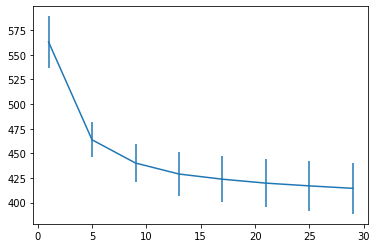

In [13]:
MSE_mean = []
MSE_std = []

for params_set in res.keys(): 
    dict_y_table = res[params_set]
    
    MSE = missing_values_treatment.compute_dict_MSE(dict_y_table)
    MSE_mean.append(MSE.mean())
    MSE_std.append(MSE.std())

params = []
for kwargs in model_selection.ParameterGrid(param_grid) :
    params.append(kwargs)

CV_results_ = {"params": params , "mean_MSE_score":MSE_mean, "std_MSE_score":MSE_std}

iterator = zip(CV_results_["mean_MSE_score"], CV_results_["std_MSE_score"], CV_results_["params"])
for mean, std, params in iterator:
    print("MSE = %0.3f (+/-%0.3f) for %s" %(mean, 2*std, params))

fig, ax = plt.subplots()
ax.errorbar(x=param_grid["n_neighbors"], y=np.array(CV_results_["mean_MSE_score"]),
            xerr=0, yerr=np.array(CV_results_["std_MSE_score"]))
plt.show()

## 4.2 Imputation valeurs manquantes

In [24]:
pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)


In [32]:
## IMPUTE :
# imputer = KNNImputer(n_neighbors=12)
# pred_std = imputer.fit_transform(X_std)
# pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

# ## INVERSE-STANDARDIZE : 
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)

# pred.to_csv(res_path+"pred_KNN_impute.csv")
# pred_std.to_csv(res_path+"pred_std_KNN_impute.csv")
 
df_pred = pd.concat([data.loc[pred.index,["product_name", "nutrition-score-fr_100g"]], pred], axis = 1)
df_pred_std = pd.concat([data.loc[pred.index,["product_name", "nutrition-score-fr_100g"]], pred_std], axis = 1)

# df_pred.to_csv(res_path+"dataframe_KNN_impute.csv")
# df_pred_std.to_csv(res_path+"dataframe_std_KNN_impute.csv")

df_pred = pd.read_csv(res_path+"dataframe_KNN_impute.csv",index_col=0)
df_pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)

In [33]:
df_pred

,product_name,nutrition-score-fr_100g,additives_n,ingredients_from_palm_oil_n,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,...,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,vitamin-b12_100g,potassium_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g
4,moutarde au moût de raisin,18.0,4.440892e-16,6.938894e-18,936.000000,215.208333,936.0,8.200000e+00,2.2,4.382222e-03,...,4.772500e-07,3.297250e-06,3.382917e-07,3.987500e-08,2.014250e-07,0.000146,7.208333e-05,0.000130,4.658333e-07,0.000026
69,BAguette bressan,-4.0,3.000000e+00,6.938894e-18,662.354167,160.000000,669.0,2.200000e+00,0.5,6.937500e-04,...,1.912500e-07,2.621917e-06,3.041667e-07,6.841667e-08,6.766667e-10,0.000363,4.841667e-05,0.000110,1.478333e-06,0.000026
329,Blanquette de Volaille et son Riz,0.0,2.000000e+00,6.938894e-18,450.000000,110.500000,450.0,2.200000e+00,0.9,6.575000e-04,...,2.429983e-05,1.580472e-06,1.680000e-07,7.828333e-08,5.043333e-10,0.000097,2.525000e-05,0.000089,8.625000e-07,0.000026
332,Salade Cesar,6.0,3.000000e+00,1.000000e+00,1068.083333,290.000000,1210.0,1.200000e+01,7.0,5.780000e-03,...,5.315750e-07,7.300000e-06,2.575517e-05,1.181424e-05,1.277500e-09,0.000259,2.981556e-19,0.000319,2.032879e-20,0.000103
352,Entremets Crème Brulée,2.0,4.000000e+00,6.938894e-18,1952.400000,460.333333,1952.4,1.530000e+01,11.2,5.894375e-03,...,4.939167e-07,3.229278e-06,3.955000e-07,5.911111e-08,1.041735e-05,0.000182,5.020833e-05,0.000122,5.579167e-07,0.000101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711396,Miel de Manuka,13.5,4.440892e-16,6.938894e-18,1350.666667,324.500000,1358.0,4.500000e-01,0.3,8.333333e-06,...,2.432500e-07,5.000000e-07,2.827500e-07,1.090833e-07,7.837500e-10,0.000778,3.804167e-05,0.000043,4.206667e-07,0.000101
1712359,Gambas sauvages de Sumatra,-3.0,1.000000e+00,6.938894e-18,351.317500,77.000000,322.0,9.000000e-01,0.4,2.602085e-18,...,1.382500e-07,7.788125e-06,4.378333e-07,5.458333e-08,1.210000e-09,0.000150,4.604167e-05,0.000197,5.472222e-07,0.000043
1712906,ฟูโด้เค้ก,26.0,5.000000e-01,6.938894e-18,1865.611111,444.000000,1860.0,1.670000e+01,11.1,5.502500e-03,...,5.004167e-07,5.682833e-06,3.675000e-07,9.593667e-08,4.666667e-10,0.000090,5.600708e-03,0.000077,3.060833e-06,0.000028
1712977,Sauce rouleaux de printemps,14.5,1.000000e+00,6.938894e-18,1119.583333,263.000000,1100.0,8.000000e-01,0.4,9.983333e-05,...,5.665833e-07,5.057639e-06,2.430929e-06,3.250000e-08,7.503214e-09,0.000236,3.200000e-05,0.000161,1.552500e-06,0.000082
